<a href="https://colab.research.google.com/github/eycooper/CovidHesitancy/blob/main/Final_Code_Submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install geopandas
!pip install geoplot
!pip install pysal
!pip install plotly

     |████████████████████████████████| 1.0 MB 4.9 MB/s 
     |████████████████████████████████| 15.4 MB 27.4 MB/s 
     |████████████████████████████████| 6.3 MB 51.0 MB/s 
     |████████████████████████████████| 10.8 MB 6.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 9.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 12.1 MB 8.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 19.3 MB 1.2 MB/s 
     |████████████████████████████████| 219 kB 60.8 MB/s 
  Created wheel for cartopy: filename=Cartopy-0.19.0.post1-cp37-cp37m-linux_x86_64.whl size=12516283 sha256=1d492c92e4884fa70bfe7c5286f9596583789207500b56f3de27ea9f7fc1deeb
  Stored in directory: /root/.cache/pip/wheels/98/01/f7/bd1

## Package Setup

In [1]:
#Import Packages
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from yellowbrick.regressor import ResidualsPlot
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import geoplot as gplt
import geopandas as gpd
import geoplot.crs as gcrs
import imageio
import pathlib
import mapclassify as mc
from shapely import wkt
import plotly.express as px

#Open Drive to access file content

from google.colab import drive
drive.mount('/content/drive')

/usr/local/lib/python3.7/dist-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


Mounted at /content/drive


## Data Load

In [2]:
#Read in Data
vacc_hes = pd.read_csv('/content/drive/MyDrive/DS5100/vacc_hes_by_county.csv')
county_election = pd.read_csv('/content/drive/MyDrive/DS5100/County_level_election.csv')

#Aggregate Data
final_df = pd.merge(vacc_hes, county_election, how="left", left_on="FIPS Code", right_on="combined_fips")
final_df['political_affiliation'] = np.where(final_df['per_dem'] > final_df['per_gop'], "Democrat", "Republican")
final_df.head()

,FIPS Code,County Name,State,Estimated hesitant,Estimated hesitant or unsure,Estimated strongly hesitant,Social Vulnerability Index (SVI),SVI Category,CVAC level of concern for vaccination rollout,CVAC Level Of Concern,Percent adults fully vaccinated against COVID-19 (as of 6/10/21),Percent Hispanic,Percent non-Hispanic American Indian/Alaska Native,Percent non-Hispanic Asian,Percent non-Hispanic Black,Percent non-Hispanic Native Hawaiian/Pacific Islander,Percent non-Hispanic White,Geographical Point,State Code,County Boundary,State Boundary,votes_dem,votes_gop,total_votes,per_dem,per_gop,diff,per_point_diff,state_abbr,county_name,combined_fips,Unnamed: 10,political_affiliation
0,1123,"Tallapoosa County, Alabama",ALABAMA,0.1806,0.2400,0.1383,0.89,Very High Vulnerability,0.64,High Concern,0.305,0.0242,0.0022,0.0036,0.2697,0.0000,0.6887,POINT (-86.844516 32.756889),AL,"MULTIPOLYGON (((-85.841259 33.104456, -85.8409...","MULTIPOLYGON (((-88.139988 34.581703, -88.1352...",5271.0,12967.0,18504.0,0.284857,0.700767,"7,696",41.59%,AL,Tallapoosa County,1123.0,NaN,Republican
1,1121,"Talladega County, Alabama",ALABAMA,0.1783,0.2350,0.1368,0.87,Very High Vulnerability,0.84,Very High Concern,0.265,0.0229,0.0043,0.0061,0.3237,0.0003,0.6263,POINT (-86.844516 32.756889),AL,"MULTIPOLYGON (((-86.303069 33.46316, -86.30306...","MULTIPOLYGON (((-88.139988 34.581703, -88.1352...",12108.0,20596.0,33218.0,0.364501,0.620025,"8,488",25.55%,AL,Talladega County,1121.0,NaN,Republican
2,1131,"Wilcox County, Alabama",ALABAMA,0.1735,0.2357,0.1337,0.93,Very High Vulnerability,0.94,Very High Concern,0.394,0.0053,0.0009,0.0003,0.6938,0.0000,0.2684,POINT (-86.844516 32.756889),AL,"MULTIPOLYGON (((-87.52534299999999 32.132773, ...","MULTIPOLYGON (((-88.139988 34.581703, -88.1352...",4329.0,1737.0,6095.0,0.710254,0.284988,"2,592",42.53%,AL,Wilcox County,1131.0,NaN,Democrat
3,1129,"Washington County, Alabama",ALABAMA,0.1735,0.2357,0.1337,0.73,High Vulnerability,0.82,Very High Concern,0.308,0.0146,0.0731,0.0025,0.2354,0.0000,0.6495,POINT (-86.844516 32.756889),AL,"MULTIPOLYGON (((-88.45317899999999 31.505388, ...","MULTIPOLYGON (((-88.139988 34.581703, -88.1352...",2366.0,6031.0,8492.0,0.278615,0.710198,"3,665",43.16%,AL,Washington County,1129.0,NaN,Republican
4,1133,"Winston County, Alabama",ALABAMA,0.1805,0.2313,0.1379,0.70,High Vulnerability,0.80,High Concern,0.163,0.0315,0.0034,0.0016,0.0073,0.0005,0.9370,POINT (-86.844516 32.756889),AL,"MULTIPOLYGON (((-87.63656399999999 34.120908, ...","MULTIPOLYGON (((-88.139988 34.581703, -88.1352...",871.0,9225.0,10255.0,0.084934,0.899561,"8,354",81.46%,AL,Winston County,1133.0,NaN,Republican


## Data Pre-Processing

In [4]:
#Data Pre-processing

predictor_cols=[6, 10, 11,12,13,14,15,16,24,25]

def convert(data):
    number = preprocessing.LabelEncoder()
    float_cols_vec = [3,4,5,6,8,10,11,12,13,14,15,16,22,23,24,25]
    float_cols = np.array(final_df.columns)[float_cols_vec]
    for i in float_cols:
      data[i] = pd.to_numeric(data[i],errors='coerce')
    data=data.fillna(0)
    return data

final_df_processed=convert(final_df)

#Set matrix with desired columns
col_names=[3, 4, 5, 10, 11, 13, 14, 24, 25, 32]
np.array(final_df.columns)[col_names]

#Aggregate data by state
by_state= final_df.groupby(['State'])[np.array(final_df.columns)[col_names]].mean().reset_index()
Est_hes_corr = by_state.corr().iloc[0]
by_state['political_affiliation'] = np.where(by_state['per_dem'] > by_state['per_gop'], "Democrat", "Republican")
by_state.head()

,State,Estimated hesitant,Estimated hesitant or unsure,Estimated strongly hesitant,Percent adults fully vaccinated against COVID-19 (as of 6/10/21),Percent Hispanic,Percent non-Hispanic Asian,Percent non-Hispanic Black,per_dem,per_gop,political_affiliation
0,ALABAMA,0.173507,0.231512,0.132409,0.320851,0.034864,0.007072,0.287355,0.337876,0.644119,Republican
1,ALASKA,0.217386,0.264245,0.156907,0.582296,0.053148,0.053886,0.013293,0.377159,0.528870,Republican
2,ARIZONA,0.159240,0.242547,0.121353,0.504733,0.313380,0.013267,0.018427,0.419269,0.528055,Republican
3,ARKANSAS,0.212123,0.261232,0.139901,0.338800,0.052561,0.006661,0.160659,0.306559,0.653989,Republican
4,CALIFORNIA,0.072274,0.111041,0.035807,0.506820,0.306224,0.073066,0.029845,0.503740,0.433299,Democrat


## Correlation Matrix

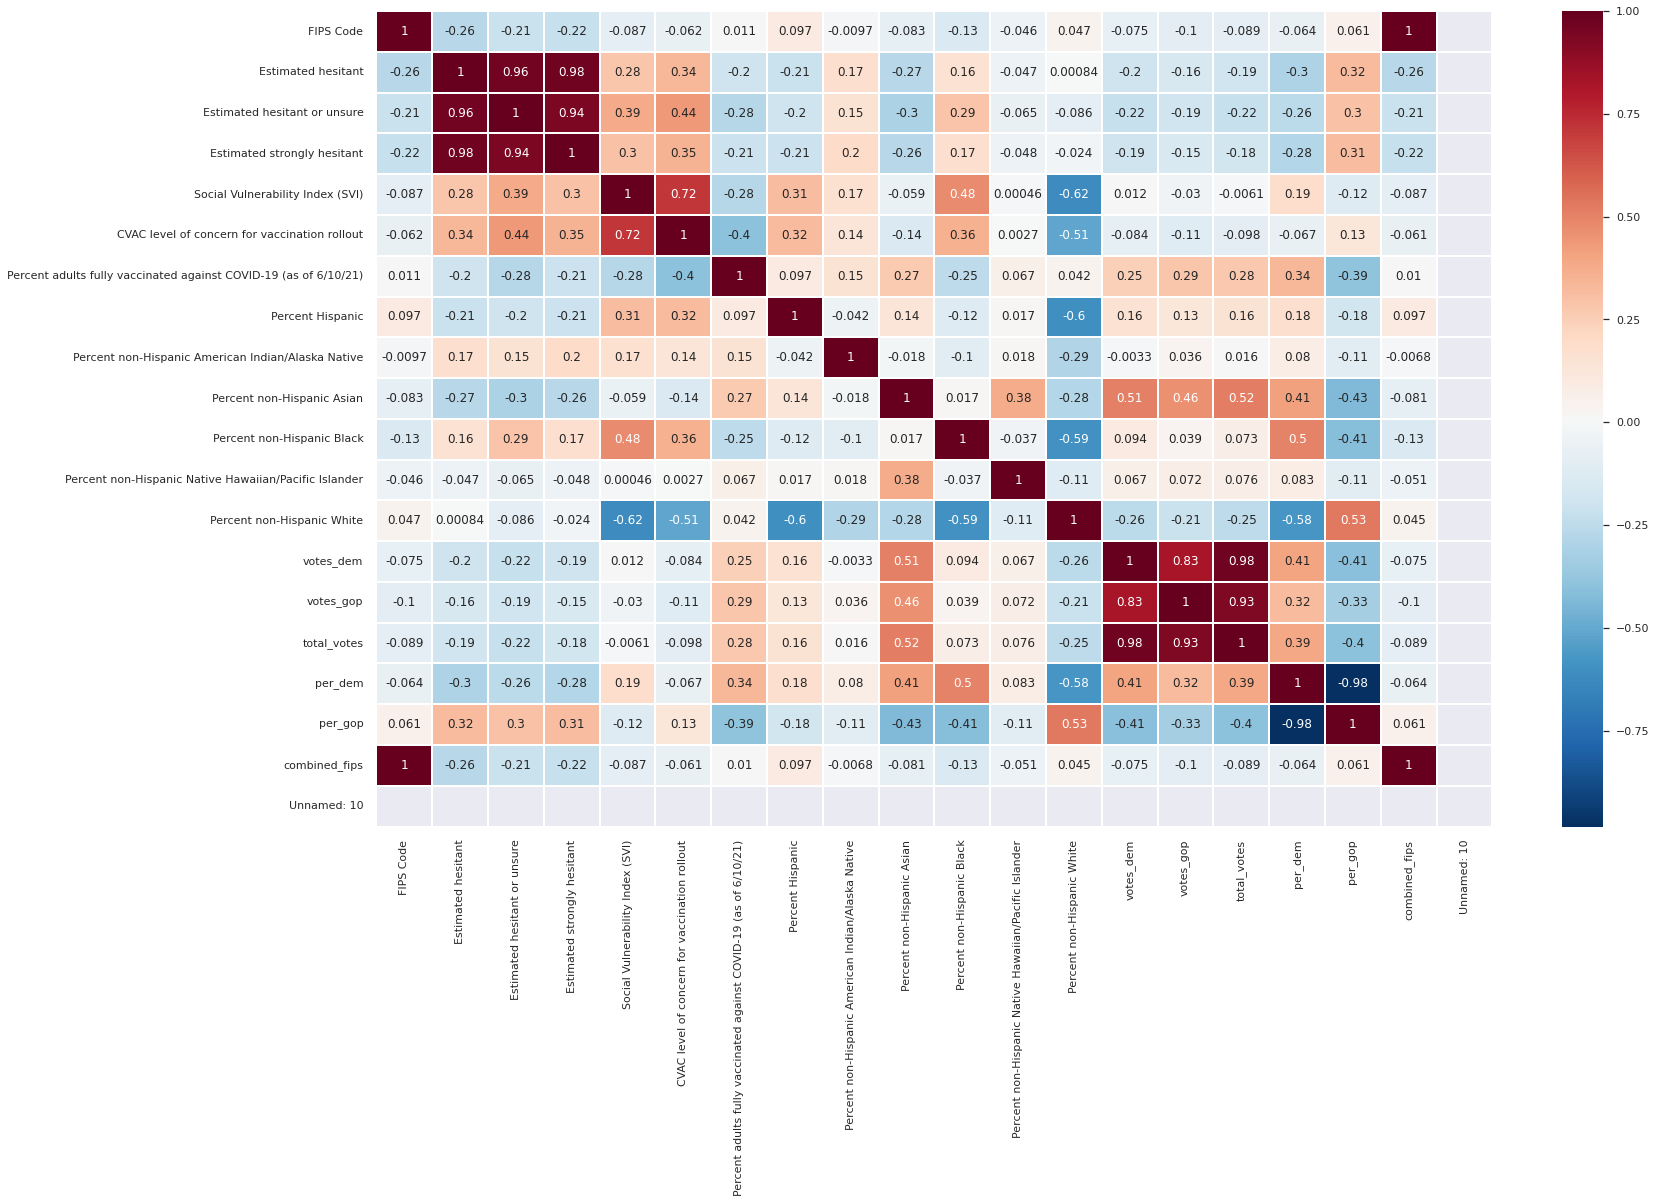

In [6]:
corr_matrix = final_df.corr()

sns.set(rc = {'figure.figsize':(25,15)})
sns.heatmap(corr_matrix, 
            xticklabels=corr_matrix.columns,
            yticklabels=corr_matrix.columns,
            cmap='RdBu_r',
            annot=True,
            linewidth=1)

## Initial Analyses

In [22]:
px.scatter(final_df,
          x="Social Vulnerability Index (SVI)",
          y="Estimated hesitant",
          color="political_affiliation",
          hover_name="State",
          trendline="lowess",
          title="Scatter plot with histogram and box marginal plot and two trendlines")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



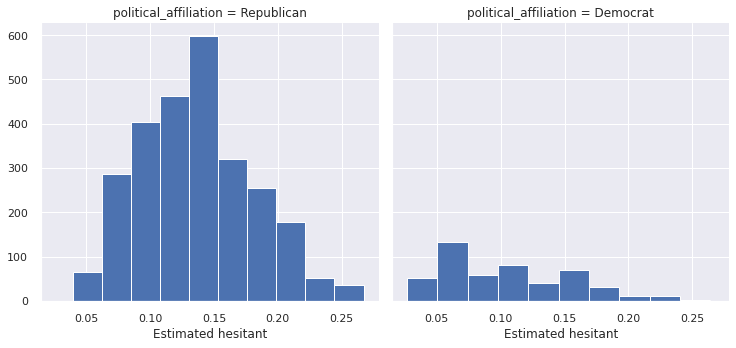

In [7]:
#Plot Estimated hesitant, broken up by political affiliation

sns.set(style = "darkgrid")
g = sns.FacetGrid(final_df, col="political_affiliation", col_wrap=5, height=5, palette="deep")
g = g.map(plt.hist, "Estimated hesitant")

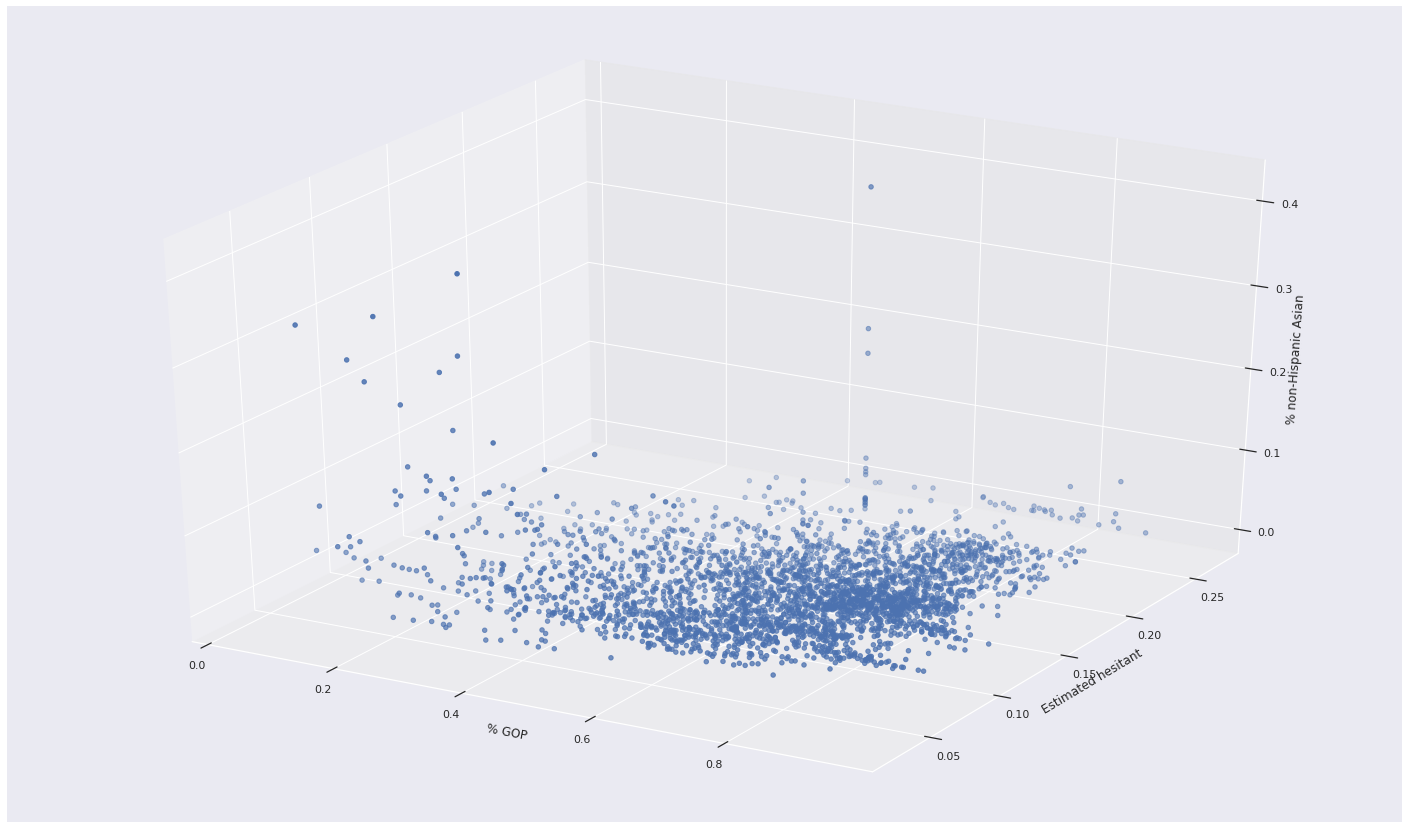

In [8]:
#3d plot with percent GOP, Estimated Hesitant, and % non-Hispanic Asian

from mpl_toolkits.mplot3d import Axes3D
sns.set(style = "darkgrid")
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
x = final_df['per_gop']
y = final_df['Estimated hesitant']
z = final_df['Percent non-Hispanic Asian']
ax.set_xlabel("% GOP")
ax.set_ylabel("Estimated hesitant")
ax.set_zlabel('% non-Hispanic Asian')
ax.scatter(x, y, z)
plt.show()

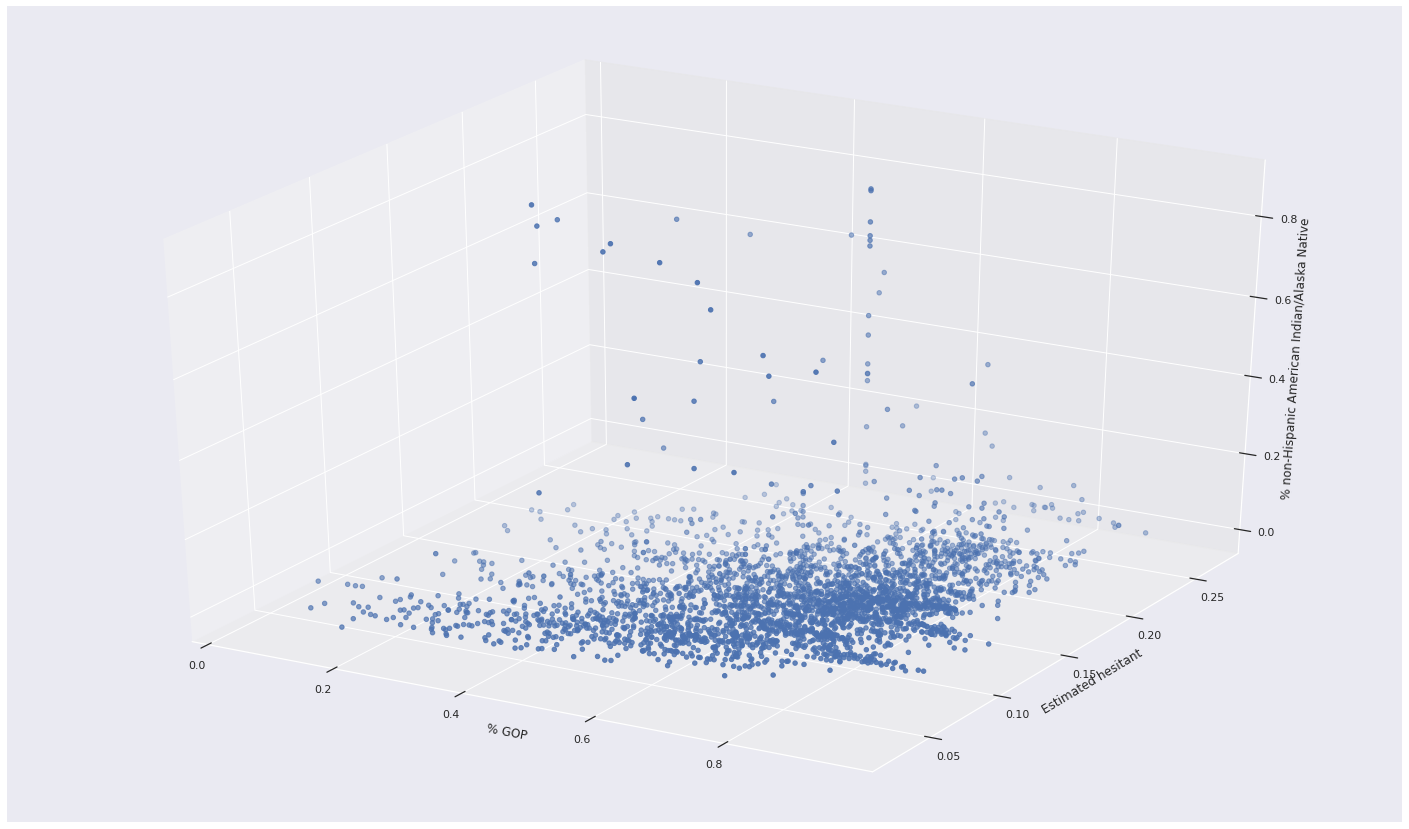

In [9]:
#3d plot with percent GOP, Estimated Hesitant, and % non-Hispanic American Indian/Alaska Native
sns.set(style = "darkgrid")
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

x = final_df['per_gop']
y = final_df['Estimated hesitant']
z = final_df['Percent non-Hispanic American Indian/Alaska Native']

ax.set_xlabel("% GOP")
ax.set_ylabel("Estimated hesitant")
ax.set_zlabel('% non-Hispanic American Indian/Alaska Native')

ax.scatter(x, y, z)
plt.show()

## Regression Analyses

In [10]:
#Train Regression Model On Full Data Set

x=np.array(final_df['per_gop'])
y=np.array(final_df['Estimated hesitant'])
x=np.nan_to_num(x)
y=np.nan_to_num(y)

x= x.reshape(-1, 1)
y= y.reshape(-1, 1)

model = LinearRegression(fit_intercept =True).fit(x, y)
model.score(x, y)

0.10245560543690757

AttributeError: ignored

TypeError: ignored

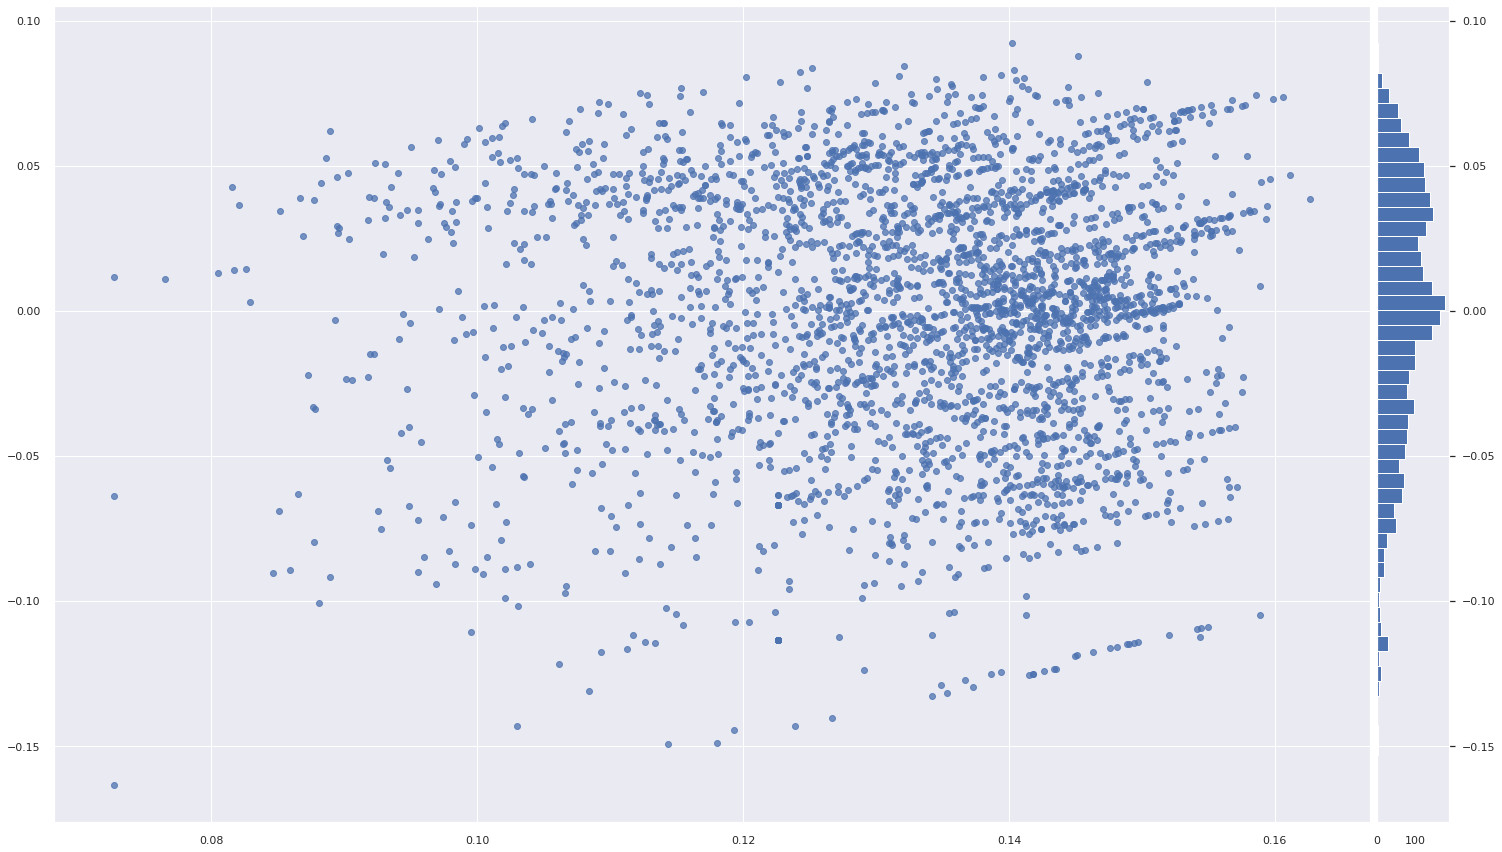

In [11]:
#Plot Residuals
from yellowbrick.regressor import ResidualsPlot

visualizer = ResidualsPlot(model)
visualizer.fit(x, y)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



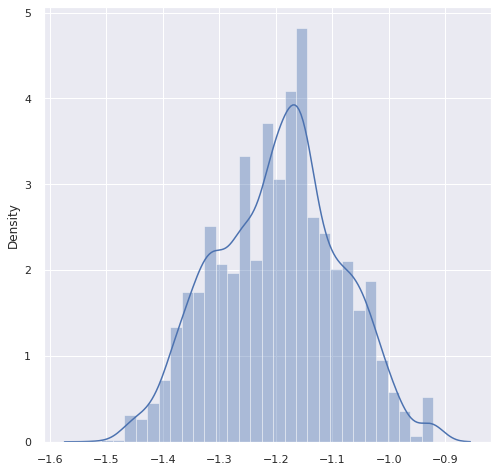

In [12]:
#Transformation
from scipy import stats

prediction = model.predict(x)
residual = np.array(y - prediction)

tdata = stats.boxcox(y.flatten())[0]
plt.figure(figsize = (8, 8))
sns.distplot(tdata)
plt.show()

In [13]:
## Lambda value of -1 suggests transformation y_star=1/y
y_star = 1/y
model2 = LinearRegression(fit_intercept =True).fit(x, y_star)
model2.score(x, y_star)

0.1716250982542582

In [14]:
print("beta_0 (intercept value): ", model2.intercept_)
print("beta_1 (slope value): ", model2.coef_)

beta_0 (intercept value):  [15.03321338]
beta_1 (slope value):  [[-9.96173623]]


In [15]:
#Use data aggregated by state, with equal weight per county
x=np.array(by_state['per_gop'])
y=np.array(by_state['Estimated hesitant'])
x=np.nan_to_num(x)
y=np.nan_to_num(y)

x= x.reshape(-1, 1)
y= y.reshape(-1, 1)

model3 = LinearRegression().fit(x, y)
model3.score(x, y)

0.36214321596080934

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



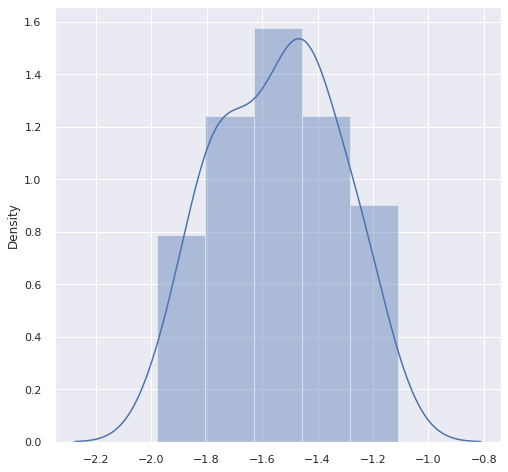

In [16]:
#Transformation for model using State aggregated data
prediction = model.predict(x)
residual = np.array(y - prediction)
residual

tdata = stats.boxcox(y.flatten())[0]
plt.figure(figsize = (8, 8))
sns.distplot(tdata)
plt.show()

In [17]:
#Update model to use transformed y
y_star = 1/y
model4 = LinearRegression().fit(x, y_star)
model4.score(x, y_star)

0.4852119599278858

## Random Forest Analyses

In [20]:
#Train Random Forest
predictor_cols=[6, 10, 11,12,13,14,15,16,24,25]

X = final_df_processed[np.array(final_df_processed.columns)[predictor_cols]]
y = final_df_processed['Estimated hesitant']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

# Instantiate model with 1000 decision trees
rf = RandomForestRegressor()
# Train the model on training data
rf.fit(X_train, y_train);


#Observe predictions
y_pred=rf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.025461927889713673
Mean Squared Error: 0.001134964689399788
Root Mean Squared Error: 0.033689236996402694


In [21]:
#Access Random Forest Feature Importance

feature_importance = rf.feature_importances_
col_names = np.array(final_df.columns)[predictor_cols]

feat_importance_matrix = pd.DataFrame(
    {'Column Names': col_names,
     'Feature Importance': feature_importance
    })

feat_importance_matrix.sort_values(['Feature Importance'], ascending=False)

,Column Names,Feature Importance
1,Percent adults fully vaccinated against COVID-...,0.190714
9,per_gop,0.145842
0,Social Vulnerability Index (SVI),0.117471
5,Percent non-Hispanic Black,0.108312
3,Percent non-Hispanic American Indian/Alaska Na...,0.107391
2,Percent Hispanic,0.091564
8,per_dem,0.078107
4,Percent non-Hispanic Asian,0.068498
7,Percent non-Hispanic White,0.066315
6,Percent non-Hispanic Native Hawaiian/Pacific I...,0.025785


In [28]:
y_acc = y_test - y_pred
y_acc

a1 = 0
a05 = 0
a01 = 0
for i in y_acc:
  if abs(i) <= 0.1:
    a1 = a1+1
  if abs(i) <= 0.05:
    a05 = a05+1
  if abs(i) <= 0.01:
    a01 = a01+1

acc1 = a1/len(y_acc)
acc05 = a05/len(y_acc)
acc01 = a01/len(y_acc)

print('% of Predictions within 0.1 of true value: ' + str(round(acc1,3)))
print('% of Predictions within 0.05 of true value: ' + str(round(acc05, 3)))
print('% of Predictions within 0.01 of true value: ' + str(round(acc01, 3)))

% of Predictions within 0.1 of true value: 0.988
% of Predictions within 0.05 of true value: 0.862
% of Predictions within 0.01 of true value: 0.273
